In [ ]:
# HACKATHON: SHINKASEN TRAVEL EXPERIENCE
## Gabriel Bisco Reinato
### Version 1.00.0 
#### Last updated on 10-31-2024

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Gxboost - gpu support 
import xgboost as xgb

## Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

## Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Assign directory path
directory_path = os.getcwd()
# Print current directory
print(directory_path)

# Assign file names
file_name = [f for f in os.listdir('.') if f.endswith('.csv')]
# Sort the files in decreasing alphabetical order
file_name = sorted(file_name, reverse=True)
# Print csv files 
print(file_name)

C:\Users\gbisc\Documents\hackathon
['Traveldata_train.csv', 'Traveldata_test.csv', 'Surveydata_train.csv', 'Surveydata_test.csv']


In [3]:
for file in file_name:
    df = pd.read_csv(os.path.join(directory_path, file))
    print(file)
    print(f"\nShape: {df.shape}")
    print("\nNAN Count:")
    print(df.isnull().sum())

Traveldata_train.csv

Shape: (94379, 9)

NAN Count:
ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64
Traveldata_test.csv

Shape: (35602, 9)

NAN Count:
ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      29
Arrival_Delay_in_Mins       123
dtype: int64
Surveydata_train.csv

Shape: (94379, 17)

NAN Count:
ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Servi

In [4]:
# Data extraction

# Read and merge sets

# Initialize empty lists to hold DataFrames for train and test
train_dataframes = []
test_dataframes = []

# Read each CSV file and append to the respective list with error handling
for file_name in file_name:
    try:
        df = pd.read_csv(os.path.join(directory_path, file_name))

        if 'Surveydata' in file_name:
            df = df.drop(columns=['ID'], errors='ignore')
        
        # Check if the file is train or test and append to the appropriate list
        if 'train' in file_name:
            train_dataframes.append(df)
        elif 'test' in file_name:
            test_dataframes.append(df)

    # Exception errors
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_name}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: The file '{file_name}' could not be parsed.")
    except Exception as e:
        print(f"An unexpected error occurred while reading '{file_name}': {e}")

# Combine Survey and Travel data for training
if train_dataframes:  # Only proceed if there are training DataFrames
    train_df = pd.concat([train_dataframes[0], train_dataframes[1]], axis=1)
else:
    train_df = pd.DataFrame()  # Empty DataFrame if none found

# Combine Survey and Travel data for testing
if test_dataframes:  # Only proceed if there are testing DataFrames
   test_df = pd.concat([test_dataframes[0], test_dataframes[1]], axis=1)
else:
    test_df = pd.DataFrame()  # Empty DataFrame if none found

In [5]:
# Train and Test data post merge investigation

# Get data shapes
print(f"Data shape:\nTrain: {train_df.shape}\nTest: {test_df.shape}")

# Data columns
print("\nData columns:\nTrain:")
print(train_df.columns)
print("Test:")
print(test_df.columns)

# Print data information
print("\nData info:\nTrain:")
print(train_df.info)
print("Test:\n")
print(test_df.info)

Data shape:
Train: (94379, 25)
Test: (35602, 24)

Data columns:
Train:
Index(['ID', 'Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class',
       'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins',
       'Overall_Experience', 'Seat_Comfort', 'Seat_Class',
       'Arrival_Time_Convenient', 'Catering', 'Platform_Location',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness',
       'Online_Boarding'],
      dtype='object')
Test:
Index(['ID', 'Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class',
       'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins',
       'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering',
       'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment',
       'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service',
       'Legroom

In [6]:
# Check for NaN or null values in each column
# Display the counts
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64

ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class              

In [7]:
# Data manipulation

# Droping trivial columns
train_df = train_df.drop(['ID'], axis = 1)
id_column = test_df.pop('ID') # Storing ID into variable for csv output file

# Defining categorical and numerical variables
# Creating numerical columns
num_cols = ['Age','Travel_Distance','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']
# Creating categorical variables 
cat_cols = ['Seat_Comfort', 'Seat_Class',
       'Arrival_Time_Convenient', 'Catering', 'Platform_Location',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding',
       'Gender', 'Customer_Type','Type_Travel', 'Travel_Class']

# Defining target variable
target_var = 'Overall_Experience'

<Axes: >

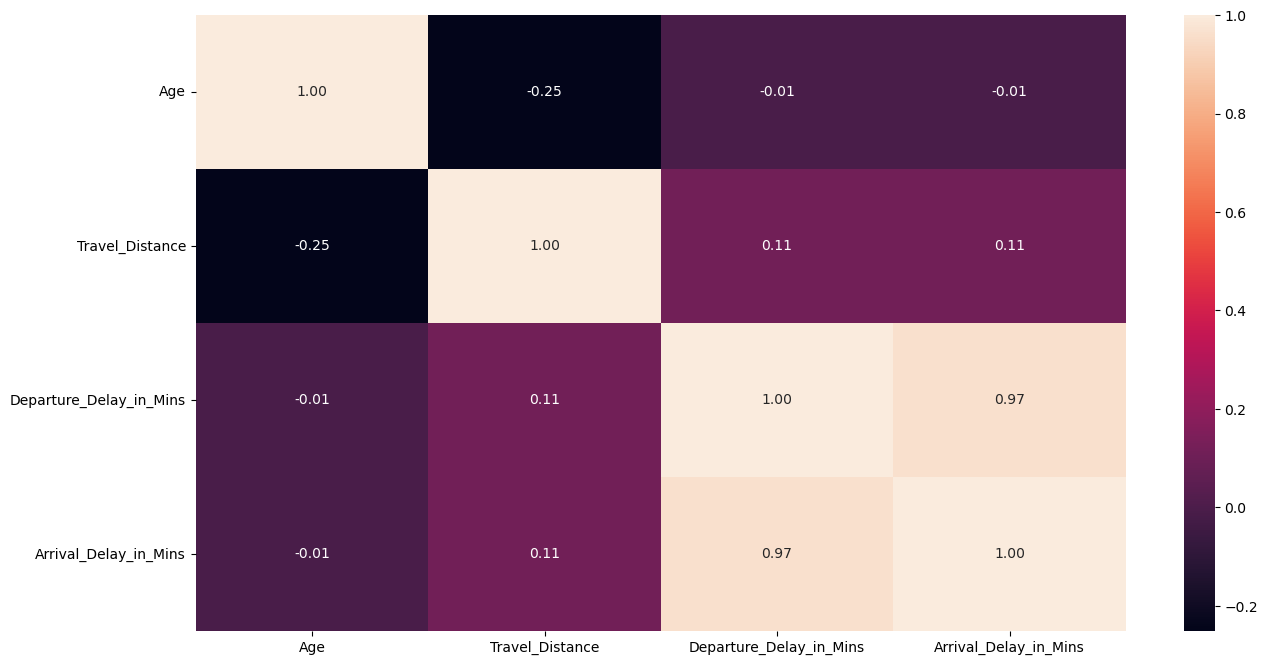

In [8]:
# Data analysis
# Plotting the correlation between numerical variables
plt.figure(figsize = (15, 8))
sns.heatmap(train_df[num_cols].corr(), annot = True, fmt = '0.2f')

In [9]:
# Check summary of numerical statistics
train_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,94346.0,39.419647,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1978.888185,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,14.647092,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,15.005222,38.439409,0.0,0.0,0.0,13.0,1584.0


In [10]:
# convert numerical data into categorical data
# definning bins and labels
# age
age_bins = [0, 15, 30, 45, 60, 100]
age_labels = ['0-15', '16-30', '31-45', '46-60', '61+']
# delay
delay_bins = [0, 10, 20, 30, 40, 50, 60, 1600]
delay_labels = ['0-10 min', '11-20 min', '21-30 min', '31-40 min', '41-50 min','51-60 min', '60+ min']
# trip distance
dist_bins = [0, 1000, 2000, 3000, 4000, 5000, 7000]
dist_labels = ['0-1000 km', '1001-2000 km', '2001-3000 km', '3001-4000 km', '4001-5000 km', '5001+ km']

# Training Data
# Converting delays
train_df['Arrival_Delay_in_Mins'] = pd.cut(train_df['Arrival_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
train_df['Departure_Delay_in_Mins'] = pd.cut(train_df['Departure_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
# Converting distance
train_df['Travel_Distance'] = pd.cut(train_df['Travel_Distance'], bins=dist_bins, labels=dist_labels, right=True)
# Converting age
train_df['Age'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=True)

# Test Data
# Converting delays
test_df['Arrival_Delay_in_Mins'] = pd.cut(test_df['Arrival_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
test_df['Departure_Delay_in_Mins'] = pd.cut(test_df['Departure_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
# Converting distance
test_df['Travel_Distance'] = pd.cut(test_df['Travel_Distance'], bins=dist_bins, labels=dist_labels, right=True)
# Converting age
test_df['Age'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels, right=True)

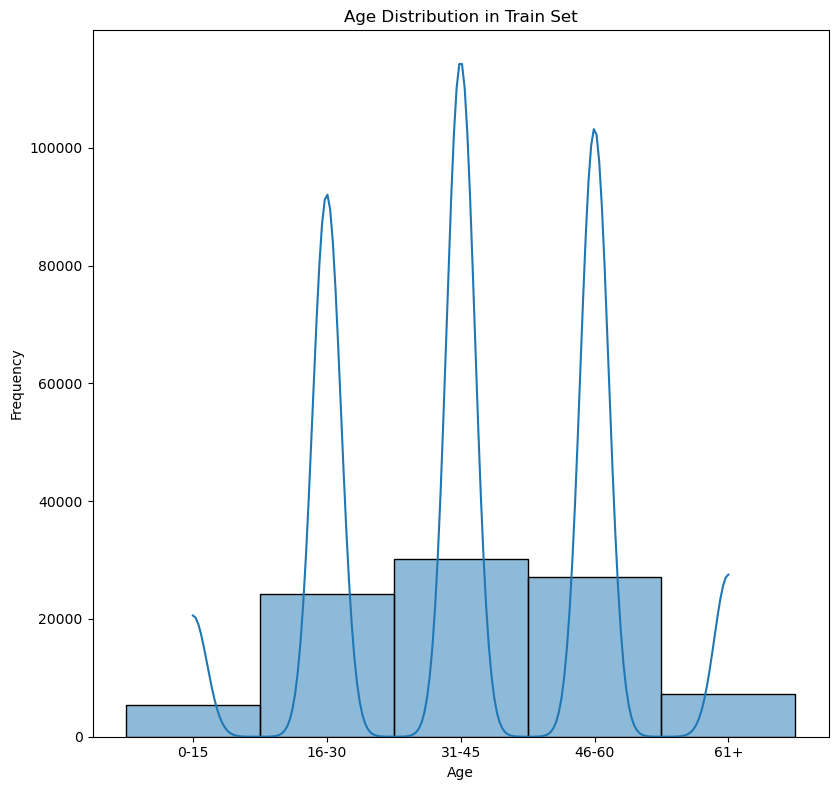

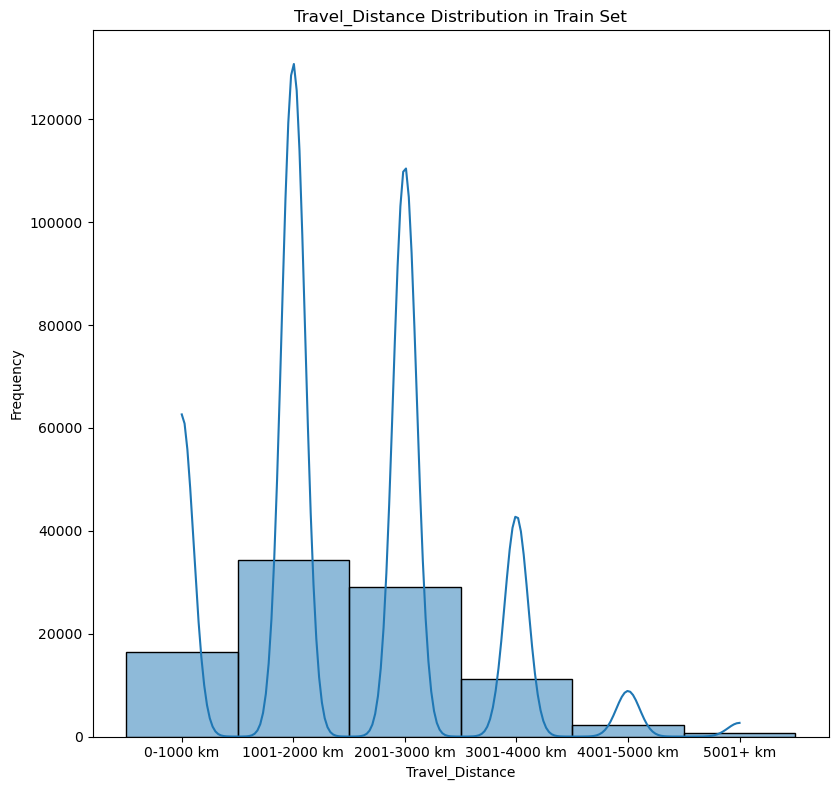

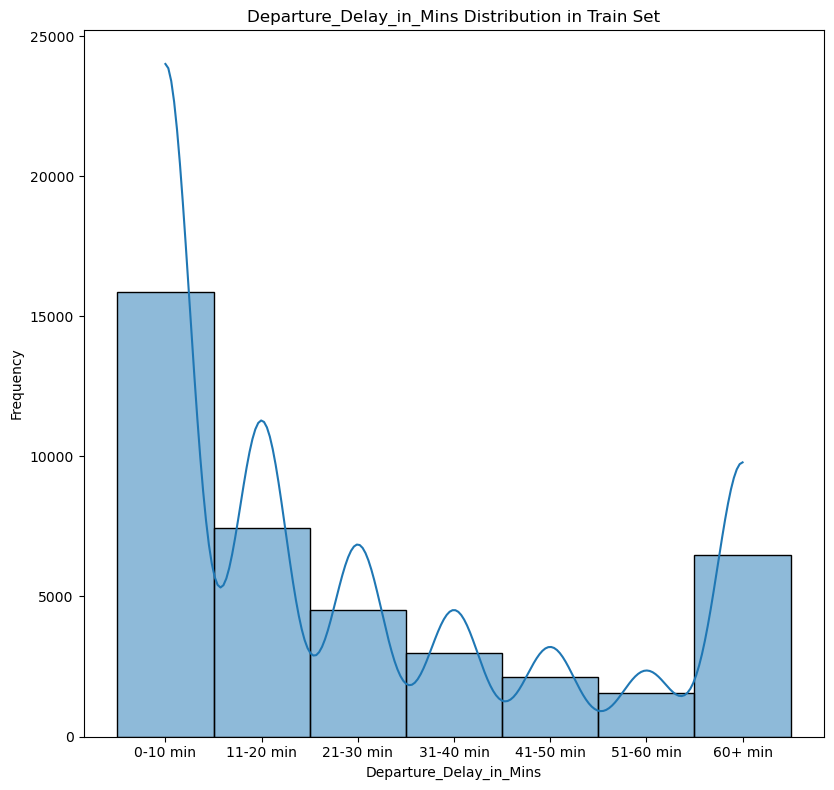

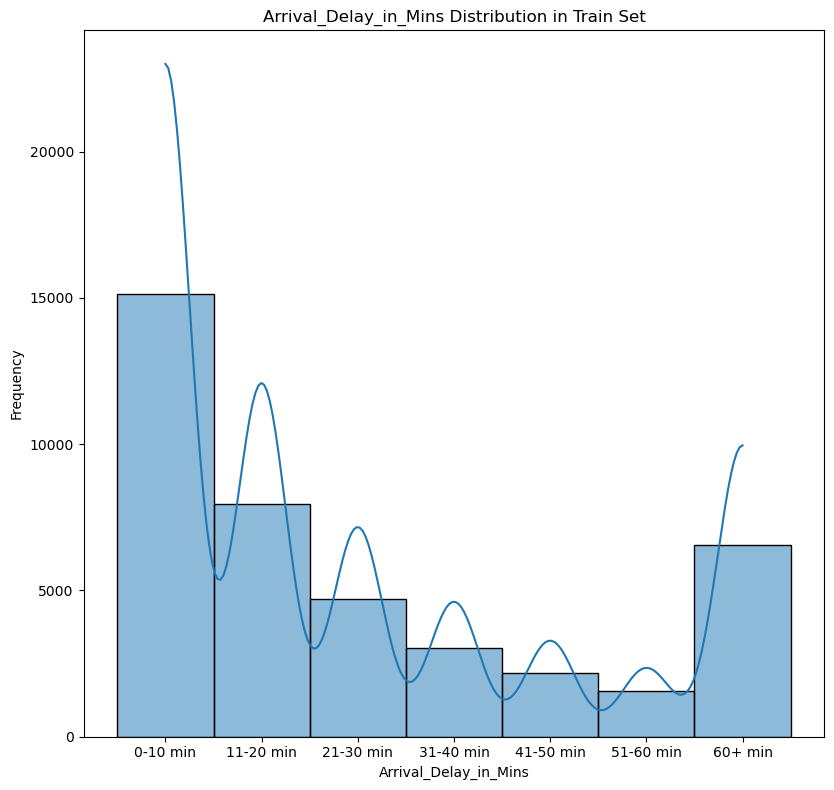

In [11]:
# Categorical analysis
# Plotting histograms
for col in num_cols:
    plt.figure(figsize=(16, 8))

    # Plot histogram for the training set
    plt.subplot(1, 2, 1)
    sns.histplot(train_df[col], kde=True, bins=80)
    plt.title(f'{col} Distribution in Train Set')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    # Show the plot
    plt.tight_layout()
    plt.show()

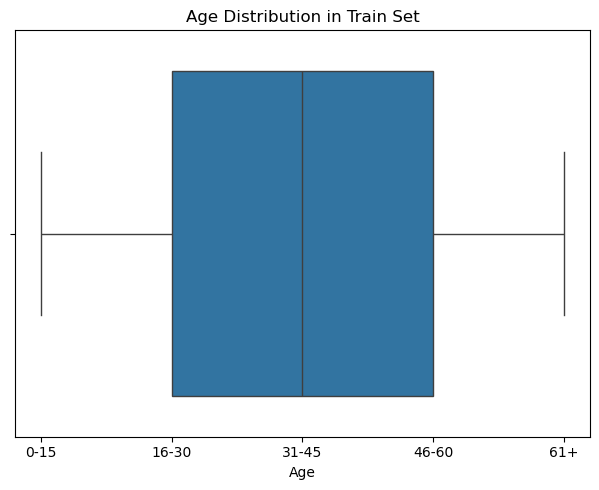

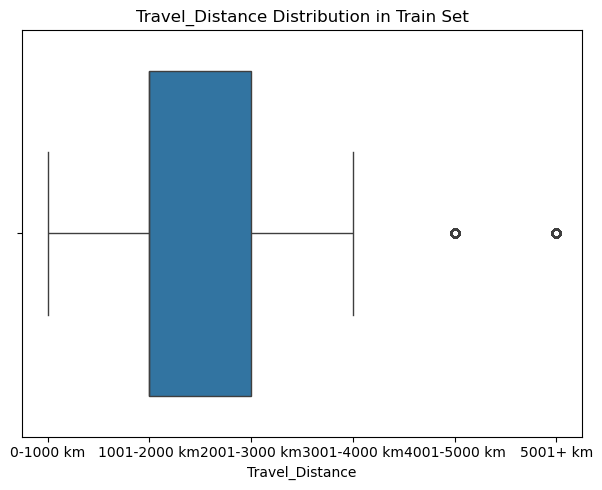

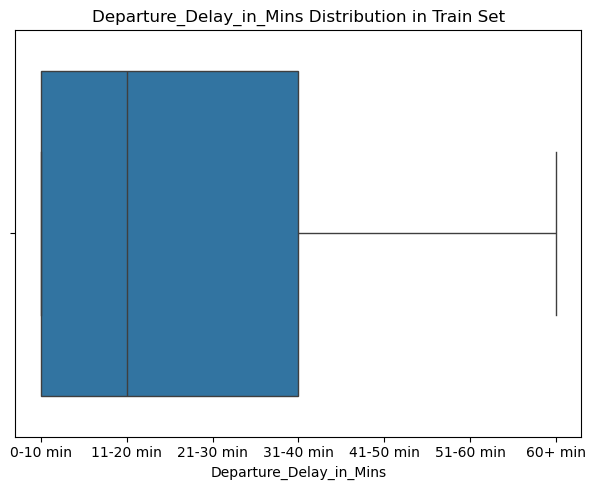

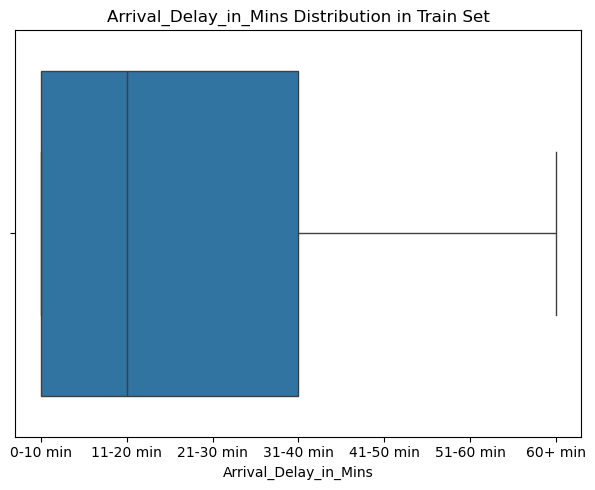

In [12]:
# Categorical analysis
# Loop over each numerical column and display box plots
for col in num_cols:
    plt.figure(figsize=(12, 5))

    # Box plot for the training set
    plt.subplot(1, 2, 1)
    sns.boxplot(x=train_df[col])
    plt.title(f'{col} Distribution in Train Set')
    plt.xlabel(col)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [13]:
# Categorical analysis
for i in train_df.columns:
    print(train_df[i].value_counts(normalize = True))
    print('*' * 40)

Gender
Female    0.507041
Male      0.492959
Name: proportion, dtype: float64
****************************************
Customer_Type
Loyal Customer       0.817332
Disloyal Customer    0.182668
Name: proportion, dtype: float64
****************************************
Age
31-45    0.320279
46-60    0.288290
16-30    0.257160
61+      0.076824
0-15     0.057448
Name: proportion, dtype: float64
****************************************
Type_Travel
Business Travel    0.688373
Personal Travel    0.311627
Name: proportion, dtype: float64
****************************************
Travel_Class
Eco         0.522807
Business    0.477193
Name: proportion, dtype: float64
****************************************
Travel_Distance
1001-2000 km    0.364710
2001-3000 km    0.309084
0-1000 km       0.174488
3001-4000 km    0.119582
4001-5000 km    0.024719
5001+ km        0.007417
Name: proportion, dtype: float64
****************************************
Departure_Delay_in_Mins
0-10 min     0.387429
11-20 mi

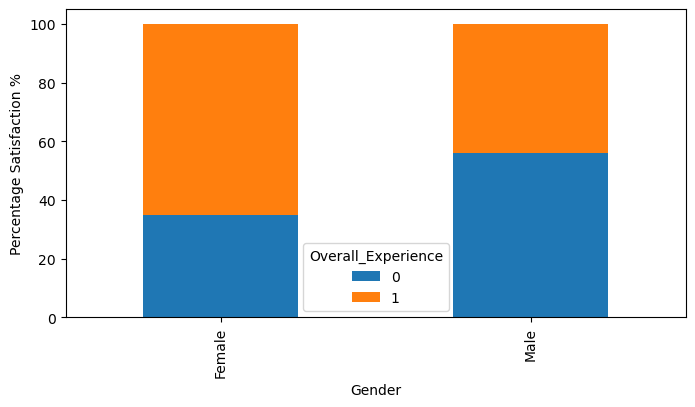

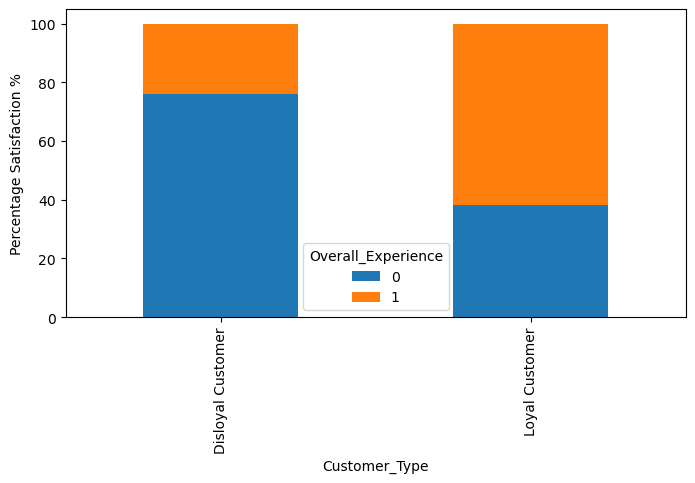

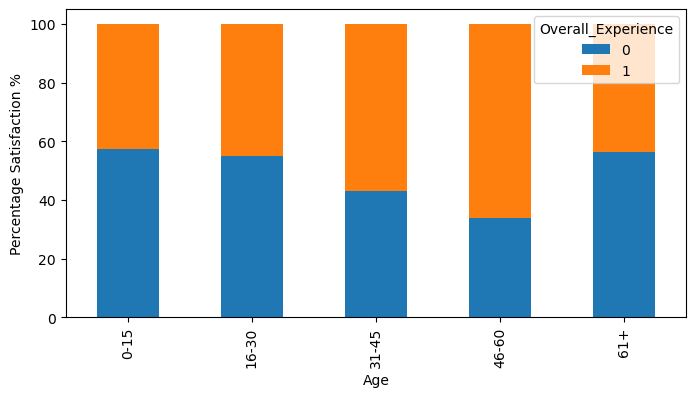

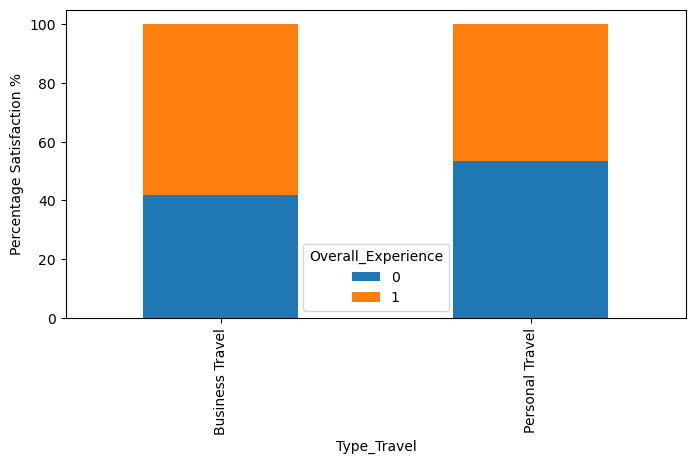

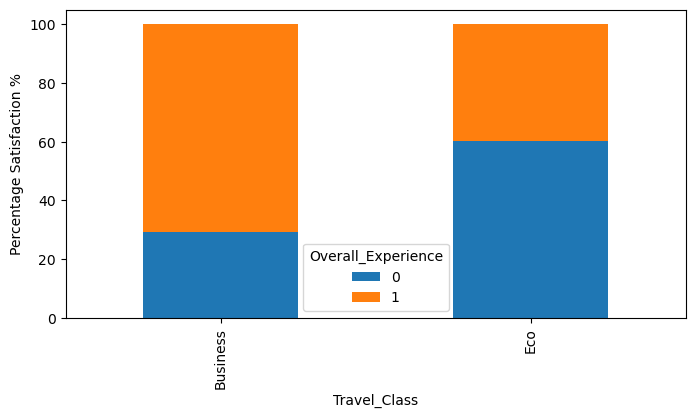

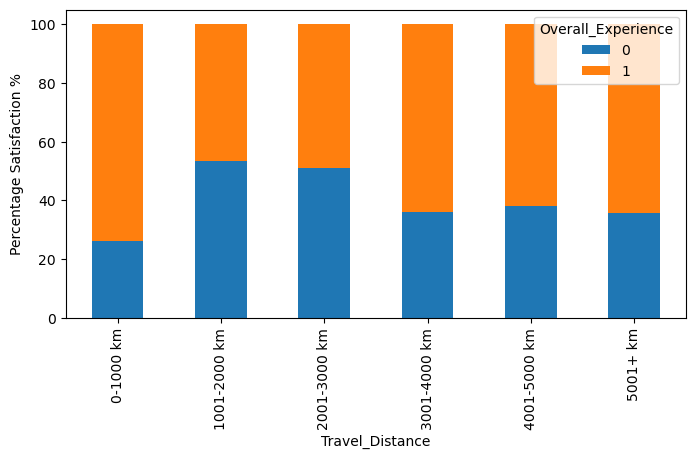

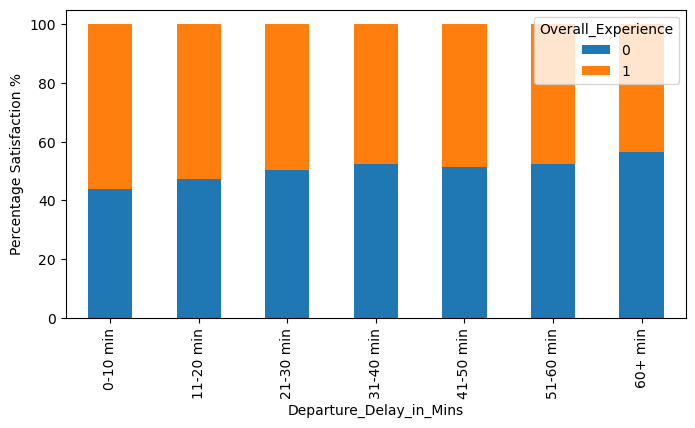

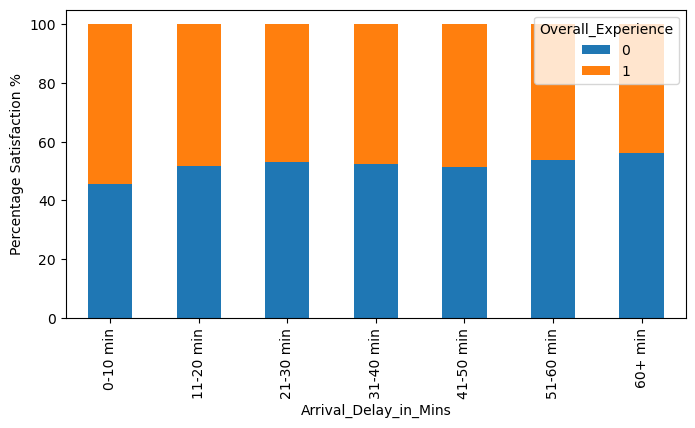

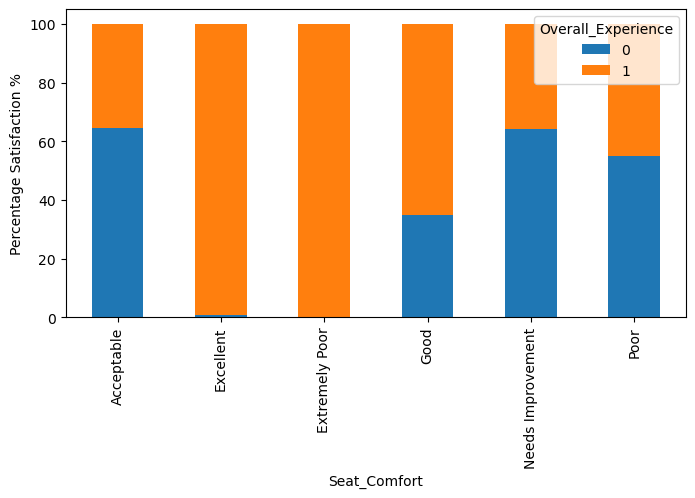

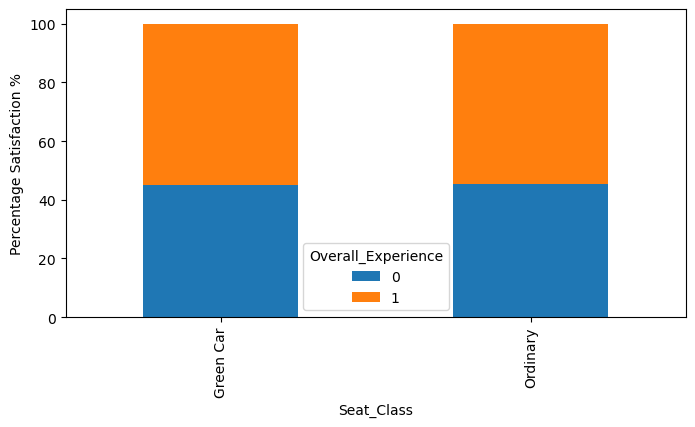

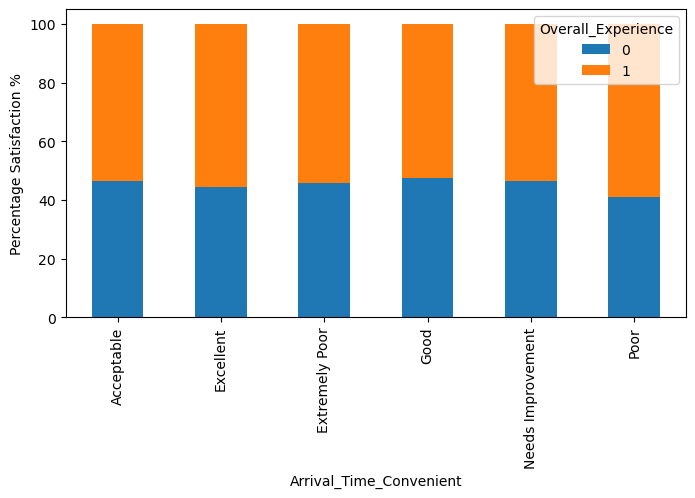

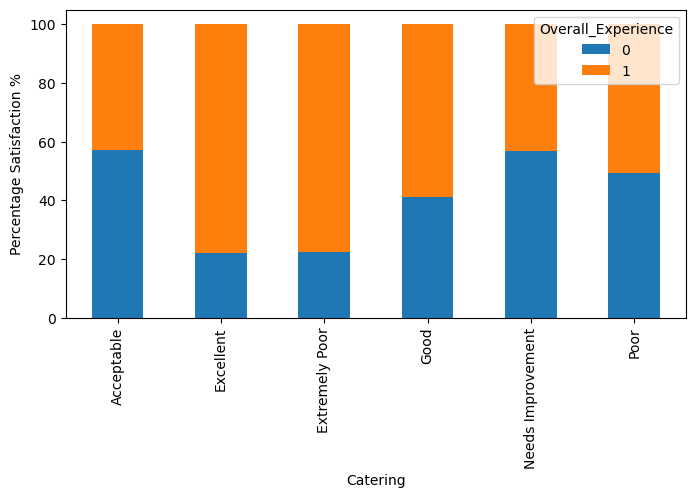

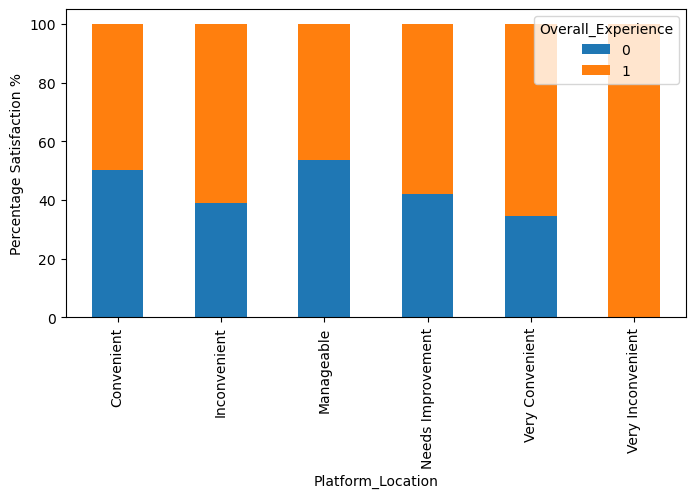

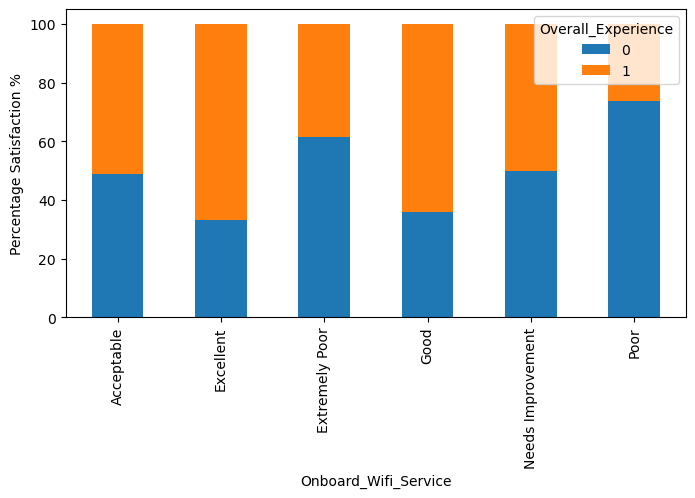

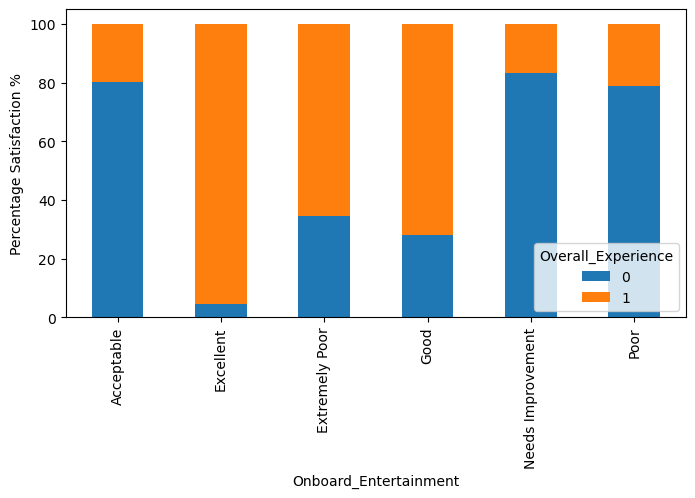

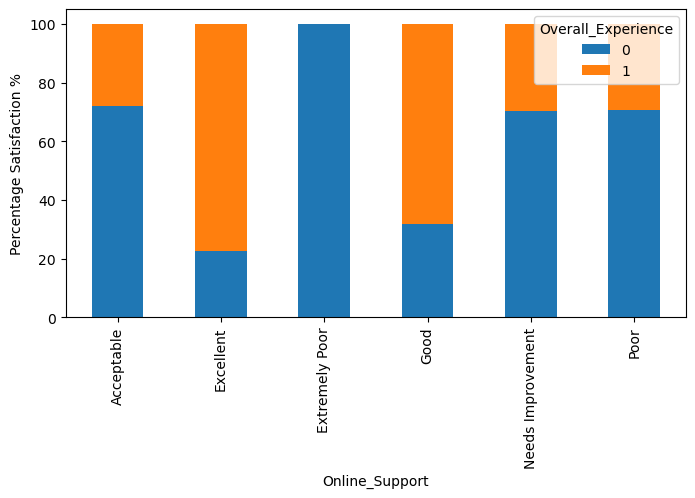

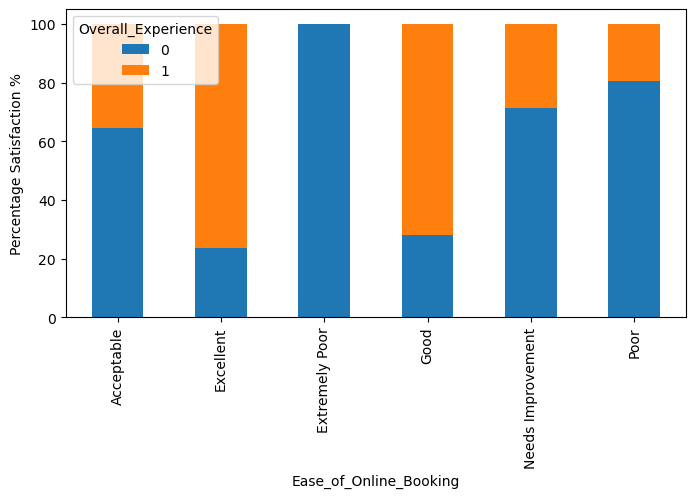

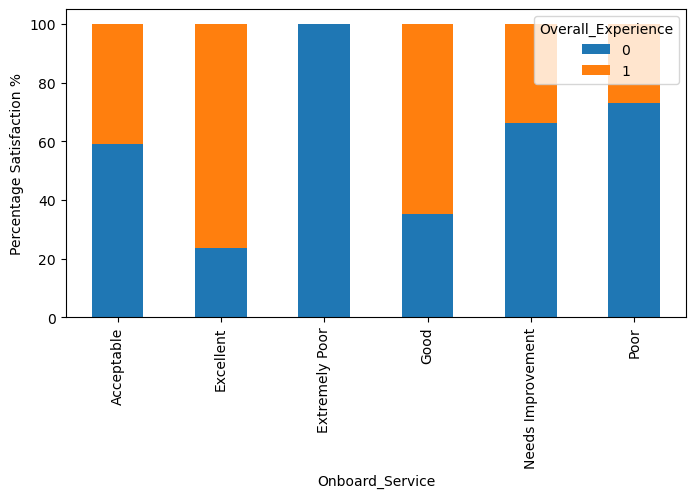

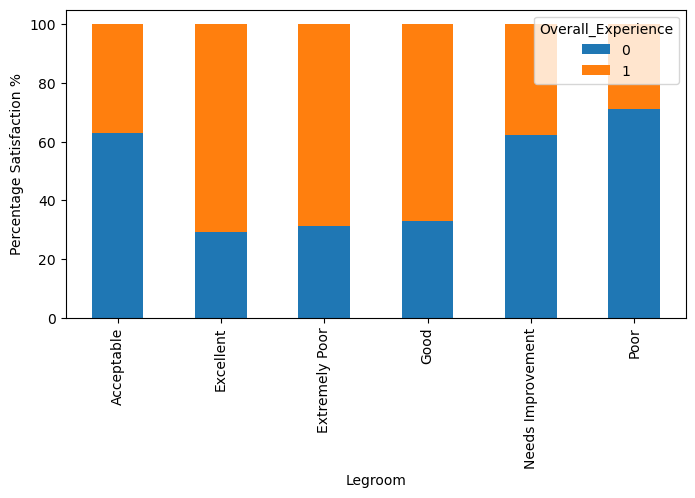

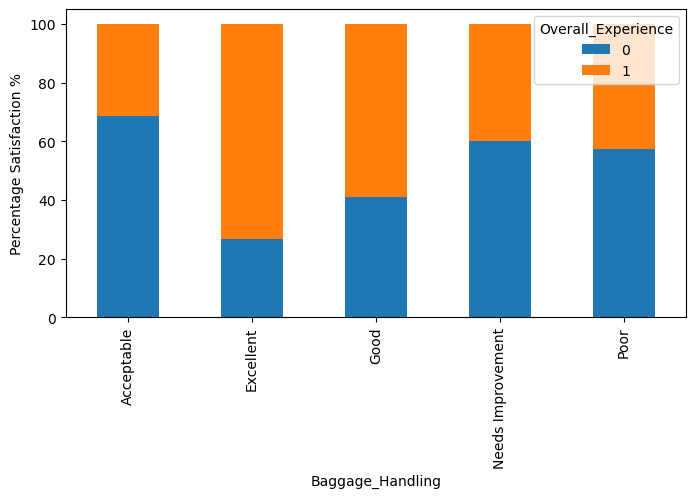

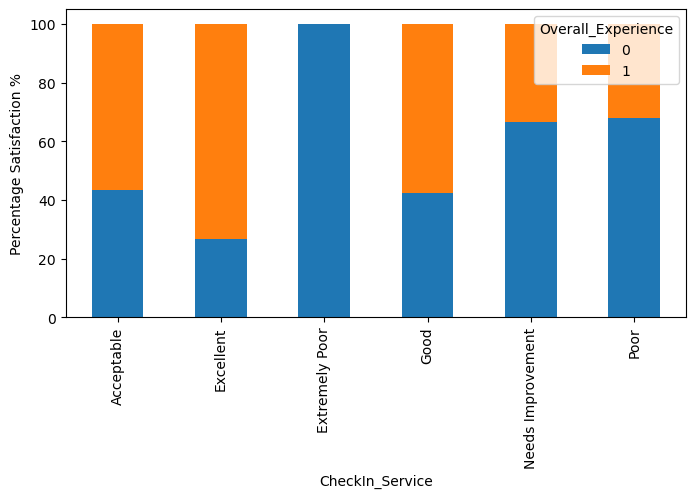

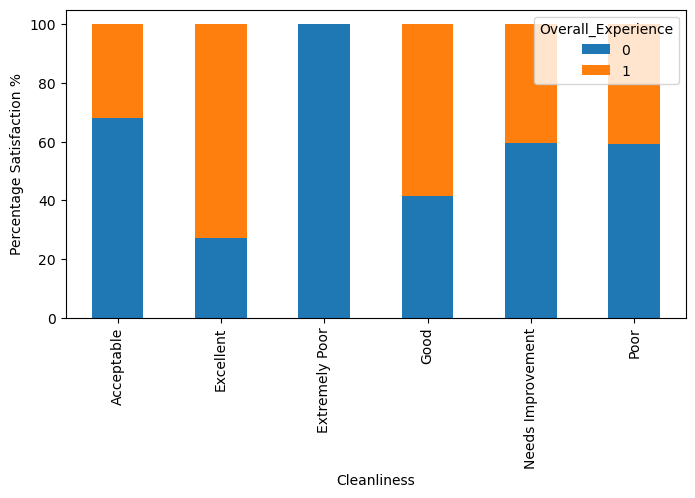

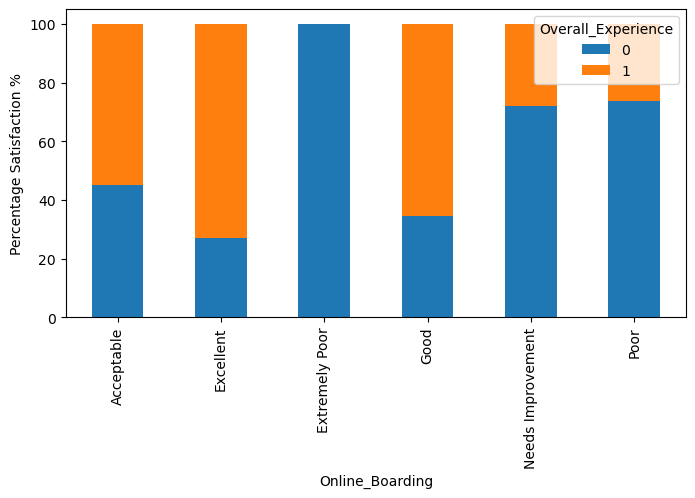

In [14]:
# Catergorical bivariate analysis
# Bar plots
for i in train_df.columns:
    if i != target_var:
        (pd.crosstab(train_df[i], train_df[target_var], normalize = 'index')*100).plot(kind = 'bar', figsize = (8, 4), stacked = True)
        plt.ylabel('Percentage Satisfaction %')

In [15]:
# Shuffle the DataFrame (optional but recommended for randomness)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
# Accounting for NaN values
# Filling unkowns on the target variable by nearest neighbor
imputer = KNNImputer(n_neighbors=4)
train_df[[target_var]] = imputer.fit_transform(train_df[[target_var]])

# Separating target variable
target_list = train_df.pop(target_var)

In [17]:
# Convert all NaN values for unkowns
# Train data
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        if pd.api.types.is_categorical_dtype(train_df[col]): 
            # Add 'Unknown' to the categories if it's not already there
            if 'Unknown' not in train_df[col].cat.categories:
                train_df[col] = train_df[col].cat.add_categories('Unknown')
            train_df[col].fillna('Unknown', inplace=True)
        else:
            train_df[col].fillna('Unknown', inplace=True)

# Test data
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        if pd.api.types.is_categorical_dtype(test_df[col]): 
            # Add 'Unknown' to the categories if it's not already there
            if 'Unknown' not in test_df[col].cat.categories:
                test_df[col] = test_df[col].cat.add_categories('Unknown')
            test_df[col].fillna('Unknown', inplace=True)
        else:
            test_df[col].fillna('Unknown', inplace=True)

In [18]:
# Check for NaN or null values in each column
# Display the counts
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())
print()
print(target_list.isnull().sum())

Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
dtype: int64

Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0


In [19]:
# Formatting data for training - testing method performance
# Separating target data
Y = target_list.copy()
X = train_df.copy()

# Cat formatting
X = pd.get_dummies(X, columns=X.columns, drop_first=True)

# Splitting the data - 80-20 split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)

# Print shapes for debugging
print(y_train.shape)
print(x_train.shape)
print(x_val.shape)
print(y_val.shape)

(75503,)
(75503, 115)
(18876, 115)
(18876,)


In [20]:
# Fitting the logistic regression model
lg = LogisticRegression()
lg.fit(x_train,y_train)

LogisticRegression()

In [21]:
# Make predictions on the trainning set
# Print trainning performance
print('Trainning performance:')
print(classification_report(y_train, lg.predict(x_train)))

Trainning performance:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     34229
         1.0       0.92      0.91      0.91     41274

    accuracy                           0.90     75503
   macro avg       0.90      0.90      0.90     75503
weighted avg       0.90      0.90      0.90     75503



In [22]:
# Make predictions on the validation set
# Print test performance
print('Validation performance:')
print(classification_report(y_val, lg.predict(x_val)))

Validation performance:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      8557
         1.0       0.91      0.90      0.91     10319

    accuracy                           0.90     18876
   macro avg       0.90      0.90      0.90     18876
weighted avg       0.90      0.90      0.90     18876



In [23]:
# Using all data for training
# Formatting data
# Cat formatting
x_train = pd.get_dummies(train_df, columns=train_df.columns, drop_first=True)
x_test = pd.get_dummies(test_df, columns= test_df.columns, drop_first=True)

# Align datasets to ensure shapes will be consistent
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

# Override trainning target variable from list
y_train = target_list.copy()

In [24]:
# Print variables shapes
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(94379, 115)
(35602, 115)
(94379,)


In [25]:
# Fitting the logistic regression model
model = LogisticRegression()
model.fit(x_train,y_train)

# Make predictions
y_pred =model.predict(x_test)

In [26]:
# Create a DataFrame
df = pd.DataFrame({
    "ID": id_column,
    "Overall_Experience": y_pred
})

# Save predictions to output csv file
df.to_csv("Regression Predictions", index=False)